In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

import math
from automaton import evaluate

In [3]:
def threshold_heuristic(automaton, tau=0):
    # default first lane is 0
    l = automaton.last_lane or 0
    # last scheduled vehicle
    k = automaton.k[l] - 1

    # next vehicle exists
    if k + 1 < automaton.K[l]:
        # earliest crossing time of next vehicle in lane
        r = automaton.instance['release'][l][k+1]

        if automaton.LB[l][k] + automaton.instance['length'][l][k] + tau >= r:
            return l

    # next lane with unscheduled vehicles
    l = (l + 1) % automaton.N
    while automaton.k[l] == automaton.K[l]:
        l = (l + 1) % automaton.N
    return l

Specify the range of $\tau$ parameter.

In [4]:
taus = np.arange(0.1, 2.1, 0.1)

Load the training data sets.

In [5]:
sets = [1,2,3,4,5,6]
train_files = [f"data/train_{i}.pkl" for i in sets]

print("\n".join(train_files))

data/train_1.pkl
data/train_2.pkl
data/train_3.pkl
data/train_4.pkl
data/train_5.pkl
data/train_6.pkl


For each instance set, plot the mean objective value for the given $\tau$.

file=data/train_1.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

file=data/train_2.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

file=data/train_3.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

file=data/train_4.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

file=data/train_5.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

file=data/train_6.pkl


  0%|          | 0/20 [00:00<?, ?it/s]

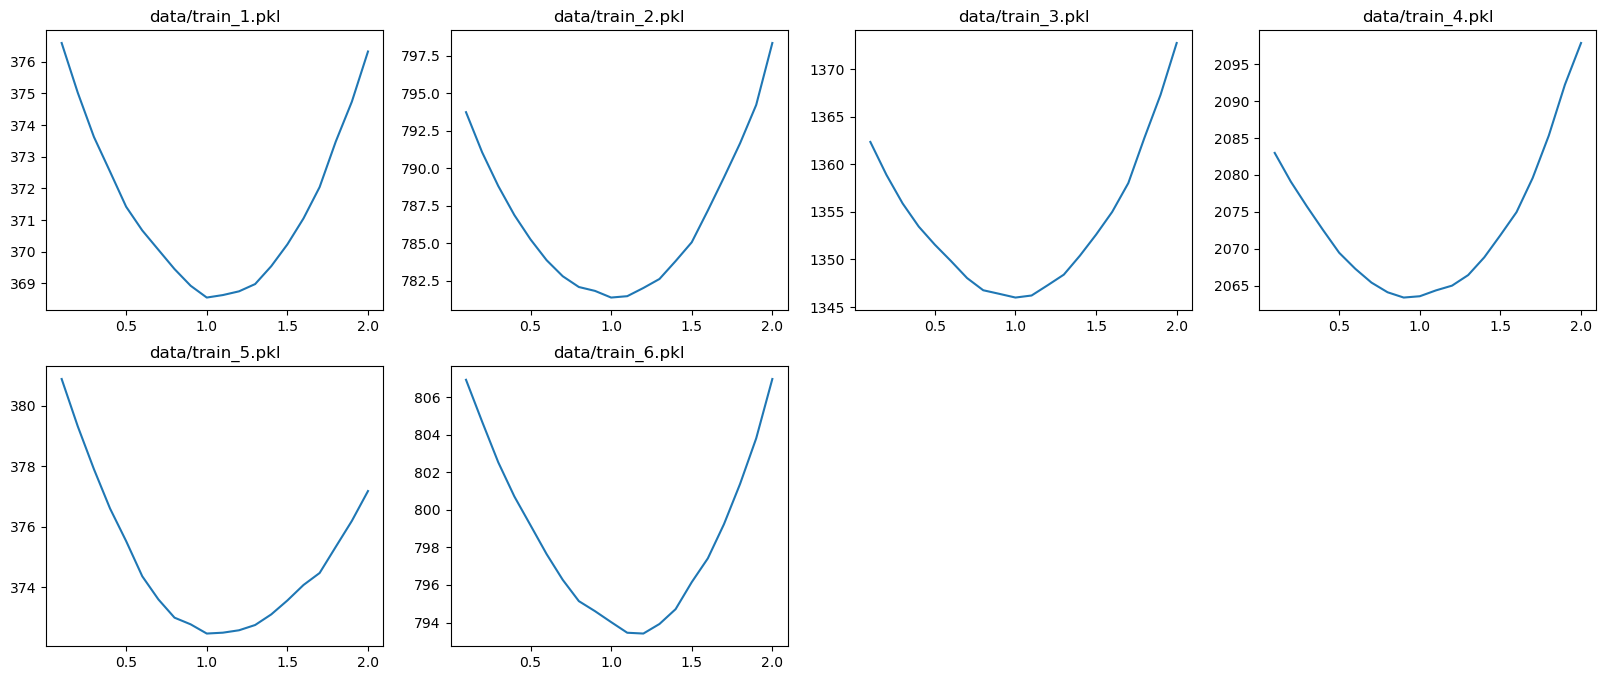

In [6]:
train_scores = np.empty((len(sets), taus.shape[0]))
plot_cols = 4
fig, axs = plt.subplots(math.ceil(len(sets) / plot_cols), plot_cols, figsize=(5*plot_cols, 8), squeeze=False)
[ax.axis('off') for ax in axs.flatten()]
for i, file in enumerate(train_files):
    print(f"file={file}")
    data = pd.read_pickle(file)

    # evaluate threshold heuristic on every instance to get average objective in
    # this set
    for j, tau in enumerate(tqdm(taus, leave=False)):
        heuristic = lambda instance: threshold_heuristic(instance, tau=tau)
        res = data.apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
        train_scores[i,j] = res.mean()

    ax = axs[i // plot_cols, i % plot_cols]
    ax.plot(taus, train_scores[i,:])
    ax.set_title(f"{file}")
    ax.axis('on')
    
plt.show()

Obtain the optimal values of $\tau$ by taking 
\begin{align}
\arg\min_\tau \frac{1}{|\mathcal{X}|} \sum_{s \in \mathcal{X}} \text{obj}(\hat{y}_\tau(s)) .
\end{align}

In [84]:
taus_opt = taus[np.argmin(train_scores, axis=1)]
pd.DataFrame(taus_opt, index=sets, columns=['tau']).T

,1,2,3,4,5,6
tau,1.1,1.1,1.0,0.9,1.1,1.1


Use found parameters to evaluate on test set.

In [85]:
test_files = [f"data/test_{i}.pkl" for i in sets]
for i, file in enumerate(test_files):
    print(f"file={file}")
    data = pd.read_pickle(file)
    
    heuristic = lambda instance: threshold_heuristic(instance, tau=taus_opt[i])
    res = data.apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
    data['threshold_obj'] = res

    data.to_pickle(file)

file=data/test_1.pkl
file=data/test_2.pkl
file=data/test_3.pkl
file=data/test_4.pkl
file=data/test_5.pkl
file=data/test_6.pkl
